In [76]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector

from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
from torch.optim.lr_scheduler import StepLR

from sklearn.datasets import fetch_openml
import cv2

In [77]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X = mnist.data / 255.0  # Normalize to [0, 1]

# Resize from 28x28 → 16x16 using OpenCV
X_resized = np.array([
    cv2.resize(img.reshape(28, 28), (16, 16), interpolation=cv2.INTER_AREA)
    for img in X
])

X_flat = X_resized.reshape(-1, 256)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_flat)

real_data = torch.tensor(X_pca, dtype=torch.float32)

In [78]:
n_qubits = 2

z_params = ParameterVector("z", n_qubits)
theta_params = ParameterVector("θ", 4)

qc = QuantumCircuit(n_qubits)

# Encode the noise inputs on each qubit
qc.ry(z_params[0], 0)
qc.ry(z_params[1], 1)

# Apply trainable rotations on each qubit
qc.ry(theta_params[0], 0)
qc.rz(theta_params[1], 0)
qc.ry(theta_params[2], 1)
qc.rz(theta_params[3], 1)

# Introduce entanglement
qc.cx(0, 1)

# Set observables for each qubit (Pauli-Z measurement)
observables = [np.array([[1, 0], [0, -1]]), np.array([[1, 0], [0, -1]])]

estimator = Estimator()
qnn_gen = EstimatorQNN(
    circuit=qc,
    input_params=z_params,
    weight_params=theta_params,
    estimator=estimator,
)

generator_layer = TorchConnector(qnn_gen)

In [79]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.qnn = TorchConnector(qnn_gen)
        self.linear = nn.Linear(1, 2)   # map 1D → 2D
        self.activation = nn.Tanh()

    def forward(self, z):
        q_out = self.qnn(z)
        return self.activation(self.linear(q_out))

generator = Generator()

In [80]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )
    
    def forward(self, x):
        return self.net(x)

discriminator = Discriminator()

In [81]:
criterion = nn.BCEWithLogitsLoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.01)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.01)

scheduler_G = StepLR(optimizer_G, step_size=50, gamma=0.9)
scheduler_D = StepLR(optimizer_D, step_size=50, gamma=0.9)

In [82]:
#Fréchet Inception Distance (FID) for 2D data

def calculate_fid(real_samples, generated_samples):
    mu1 = np.mean(real_samples, axis=0)
    mu2 = np.mean(generated_samples, axis=0)
    sigma1 = np.cov(real_samples.T)
    sigma2 = np.cov(generated_samples.T)
    ssdiff = np.sum((mu1 - mu2)**2)
    covmean = sqrtm(sigma1.dot(sigma2))
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid

In [83]:
def main():
    num_epochs = 200
    batch_size = 64
    loss_G_history = []
    loss_D_history = []
    fid_history = []

    # Early stopping parameters
    best_fid = float('inf')
    patience = 50
    counter = 0

    for epoch in range(num_epochs):
        # Train Discriminator
        optimizer_D.zero_grad()
        idx = np.random.randint(0, real_data.shape[0], batch_size)
        real_batch = real_data[idx]
        
        # Generate noise input for the generator: random values in [0, π]
        noise = torch.rand(batch_size, 2) * np.pi
        fake_batch = generator(noise)
        
        pred_real = discriminator(real_batch)
        pred_fake = discriminator(fake_batch.detach())
        
        labels_real = torch.ones(batch_size, 1)
        labels_fake = torch.zeros(batch_size, 1)
        
        loss_D = criterion(pred_real, labels_real) + criterion(pred_fake, labels_fake)
        loss_D.backward()
        optimizer_D.step()
        
        optimizer_G.zero_grad()
        fake_batch = generator(noise)
        pred_fake = discriminator(fake_batch)
        loss_G = criterion(pred_fake, labels_real)
        loss_G.backward()
        optimizer_G.step()

        # Compute FID on the current batch
        fid = calculate_fid(real_batch.detach().numpy(), fake_batch.detach().numpy())

        loss_G_history.append(loss_G.item())
        loss_D_history.append(loss_D.item())
        fid_history.append(fid)

        scheduler_G.step()
        scheduler_D.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: D Loss = {loss_D.item():.4f}, G Loss = {loss_G.item():.4f}, FID = {fid:.4f}", end = ", ")
            for param_group in optimizer_G.param_groups:
                print("Current G LR:", param_group["lr"])

        if fid + 1e-3 < best_fid:
                best_fid = fid
                counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch}. Best FID: {best_fid:.4f}")
                break

    plt.figure(figsize=(10, 4))
    plt.plot(loss_D_history, label="Discriminator Loss")
    plt.plot(loss_G_history, label="Generator Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("QGAN Loss Curves")
    plt.legend()
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(8, 4))
    plt.plot(fid_history, 'g-', label="FID Score")
    plt.xlabel("Epoch")
    plt.ylabel("FID")
    plt.title("FID Score Over Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


    with torch.no_grad():
        noise_test = torch.rand(200, 2) * np.pi
        gen_samples = generator(noise_test).numpy()

    # Plot real vs generated in 2D
    plt.figure(figsize=(6, 6))
    plt.scatter(real_data[:, 0], real_data[:, 1], color='blue', alpha=0.5, label='Real PCA')
    plt.scatter(gen_samples[:, 0], gen_samples[:, 1], color='red', alpha=0.6, label='Generated')
    plt.title("QGAN: Generated vs Real PCA-reduced MNIST")
    plt.xlabel("PCA Dim 1")
    plt.ylabel("PCA Dim 2")
    plt.legend()
    plt.grid(True)
    plt.show()


    # Invert PCA: go from 2D → 64D image
    reconstructed_imgs = pca.inverse_transform(gen_samples)
    real_imgs = pca.inverse_transform(real_data[:10])

    fig, axes = plt.subplots(2, 10, figsize=(15, 3))
    for i in range(10):
        axes[0][i].imshow(real_imgs[i].reshape(16, 16), cmap='gray')
        axes[0][i].axis('off')

        axes[1][i].imshow(reconstructed_imgs[i].reshape(16, 16), cmap='gray')
        axes[1][i].axis('off')
    axes[0, 0].set_title("Originals", fontsize=12)
    axes[1, 0].set_title("Reconstructed", fontsize=12)
    plt.tight_layout()
    plt.suptitle("QGAN: Reconstructed MNIST-like Images vs Original MNIST Samples (via PCA Inverse)", fontsize=15)
    plt.show()

Epoch 0: D Loss = 1.3124, G Loss = 0.7532, FID = 1.8128, Current G LR: 0.01
Epoch 10: D Loss = 1.1262, G Loss = 0.9291, FID = 2.3666, Current G LR: 0.01
Epoch 20: D Loss = 1.0805, G Loss = 0.8717, FID = 1.9505, Current G LR: 0.01
Epoch 30: D Loss = 1.0632, G Loss = 0.9653, FID = 1.9844, Current G LR: 0.01
Epoch 40: D Loss = 0.8953, G Loss = 1.0248, FID = 3.0389, Current G LR: 0.01
Epoch 50: D Loss = 0.8652, G Loss = 1.0357, FID = 1.6756, Current G LR: 0.009000000000000001
Epoch 60: D Loss = 0.8753, G Loss = 1.1404, FID = 1.4596, Current G LR: 0.009000000000000001
Epoch 70: D Loss = 0.8454, G Loss = 1.1179, FID = 1.3670, Current G LR: 0.009000000000000001
Epoch 80: D Loss = 0.7691, G Loss = 1.2987, FID = 1.2816, Current G LR: 0.009000000000000001
Epoch 90: D Loss = 0.7470, G Loss = 1.1681, FID = 1.6830, Current G LR: 0.009000000000000001
Epoch 100: D Loss = 0.7607, G Loss = 1.3523, FID = 1.0500, Current G LR: 0.008100000000000001
Epoch 110: D Loss = 0.7398, G Loss = 1.3880, FID = 1.3491

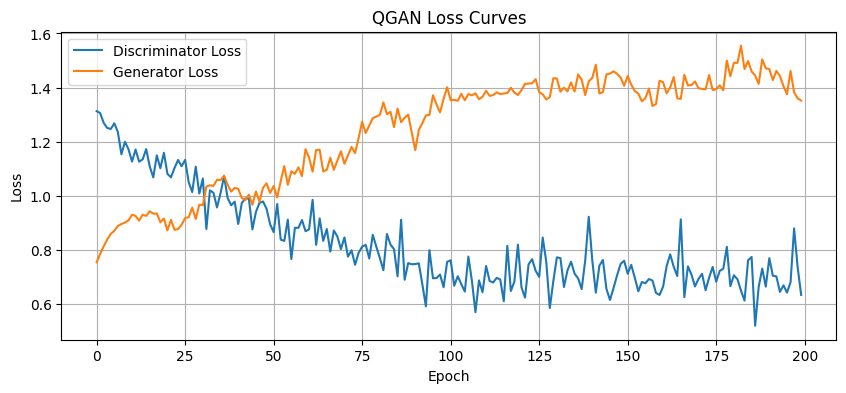

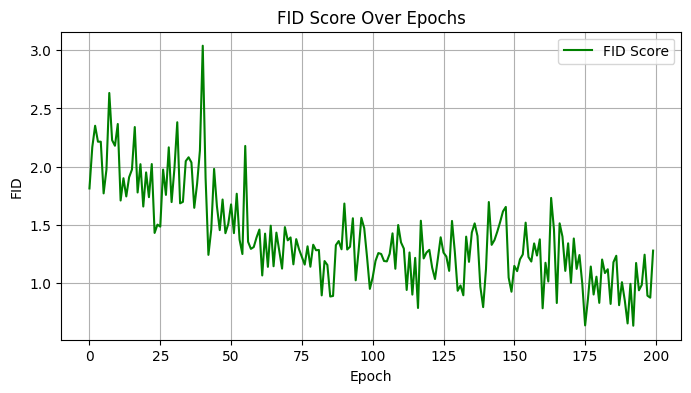

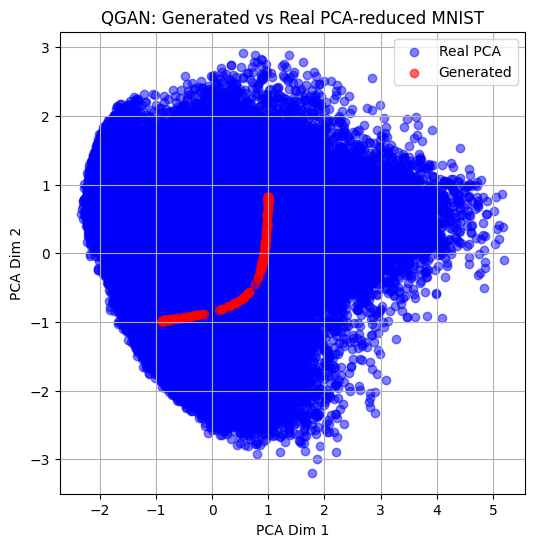

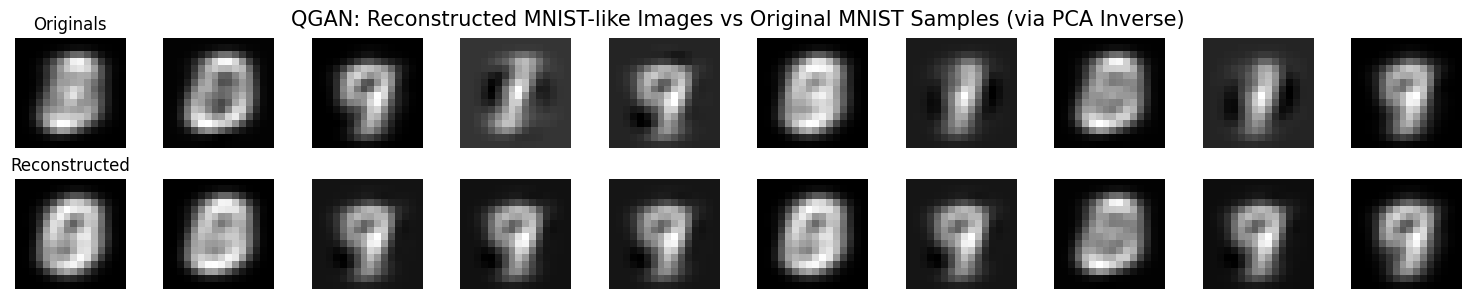

In [84]:
if __name__ == "__main__":
    main()

Epoch 0: D Loss = 0.7622, G Loss = 1.3120, FID = 0.8551, Current G LR: 0.006561000000000002
Epoch 10: D Loss = 0.8409, G Loss = 1.6067, FID = 0.5370, Current G LR: 0.006561000000000002
Epoch 20: D Loss = 0.5791, G Loss = 1.4005, FID = 0.8717, Current G LR: 0.006561000000000002
Epoch 30: D Loss = 0.5878, G Loss = 1.6528, FID = 1.3971, Current G LR: 0.006561000000000002
Epoch 40: D Loss = 0.6095, G Loss = 1.3895, FID = 1.0904, Current G LR: 0.006561000000000002
Epoch 50: D Loss = 0.6579, G Loss = 1.5020, FID = 0.8400, Current G LR: 0.005904900000000002
Epoch 60: D Loss = 0.6617, G Loss = 1.4428, FID = 0.8452, Current G LR: 0.005904900000000002
Epoch 70: D Loss = 0.6345, G Loss = 1.5957, FID = 0.8017, Current G LR: 0.005904900000000002
Epoch 80: D Loss = 0.8620, G Loss = 1.3598, FID = 0.6075, Current G LR: 0.005904900000000002
Epoch 90: D Loss = 0.6450, G Loss = 1.4767, FID = 1.0735, Current G LR: 0.005904900000000002
Early stopping at epoch 96. Best FID: 0.3519


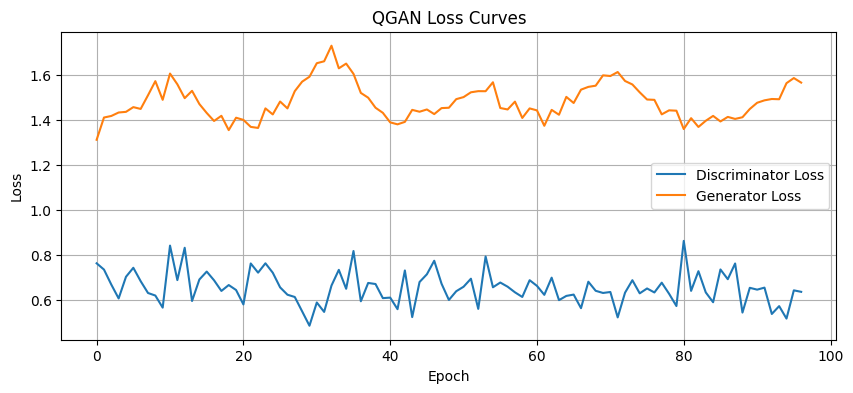

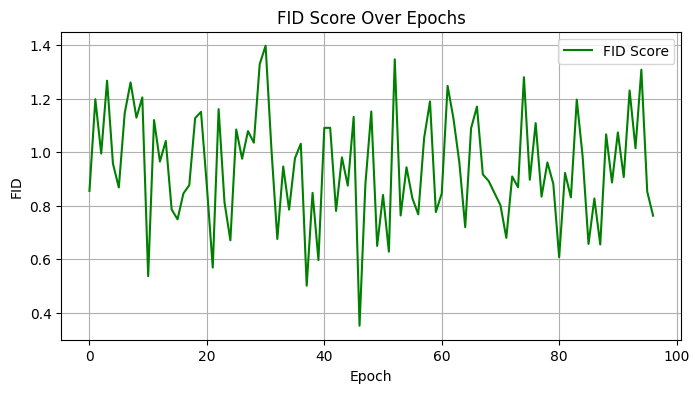

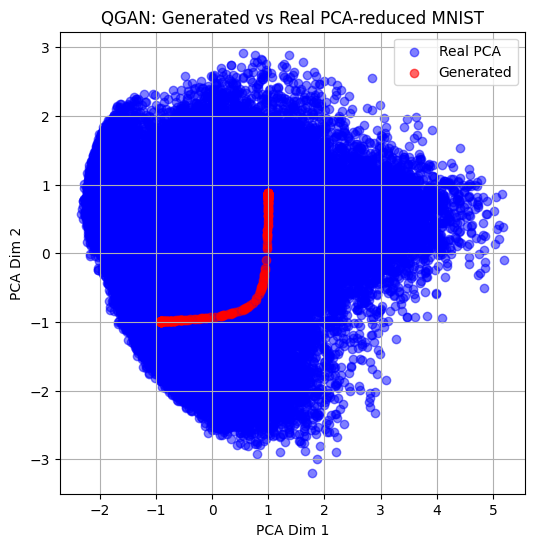

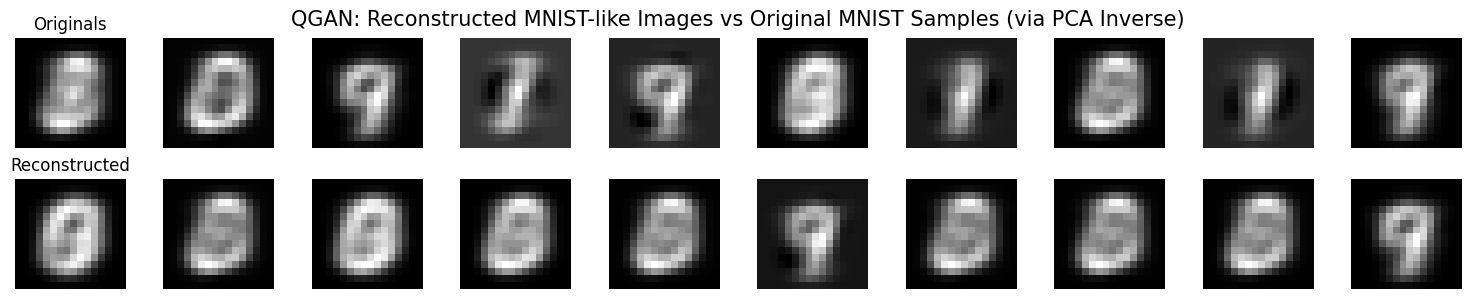

In [85]:
if __name__ == "__main__":
    main()

Epoch 0: D Loss = 0.3163, G Loss = 1.9527, FID = 2.0700, Current G LR: 0.007290000000000001
Epoch 10: D Loss = 0.3225, G Loss = 2.0144, FID = 1.9809, Current G LR: 0.007290000000000001
Epoch 20: D Loss = 0.3151, G Loss = 2.0676, FID = 1.9766, Current G LR: 0.006561000000000002
Epoch 30: D Loss = 0.3234, G Loss = 2.0701, FID = 1.7800, Current G LR: 0.006561000000000002
Epoch 40: D Loss = 0.3617, G Loss = 1.9899, FID = 1.4906, Current G LR: 0.006561000000000002
Epoch 50: D Loss = 0.3106, G Loss = 1.9805, FID = 2.1648, Current G LR: 0.006561000000000002
Epoch 60: D Loss = 0.4554, G Loss = 1.9833, FID = 1.6094, Current G LR: 0.006561000000000002
Epoch 70: D Loss = 0.6868, G Loss = 2.0236, FID = 1.3100, Current G LR: 0.005904900000000002
Epoch 80: D Loss = 0.9973, G Loss = 1.6584, FID = 0.9943, Current G LR: 0.005904900000000002
Epoch 90: D Loss = 1.2408, G Loss = 1.9962, FID = 1.1536, Current G LR: 0.005904900000000002
Epoch 100: D Loss = 0.9166, G Loss = 1.4494, FID = 0.9717, Current G LR

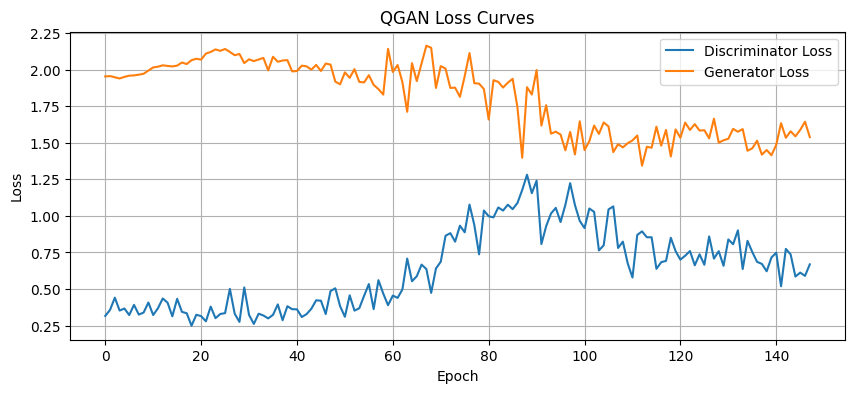

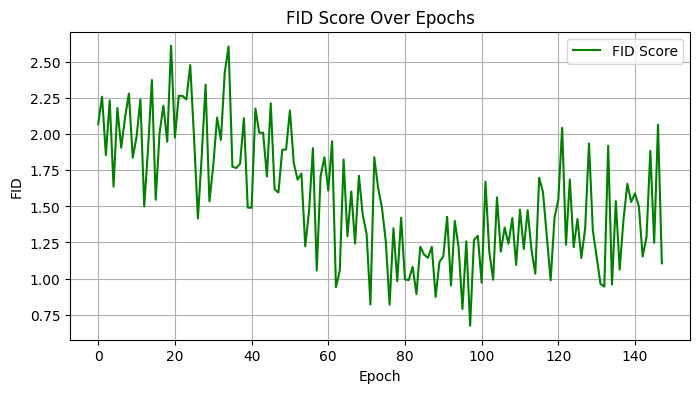

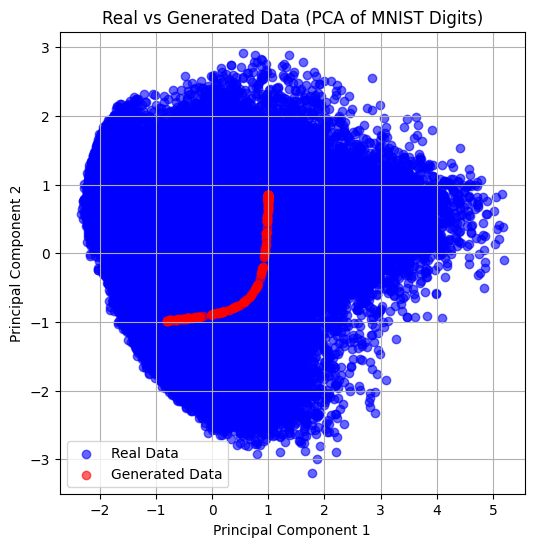

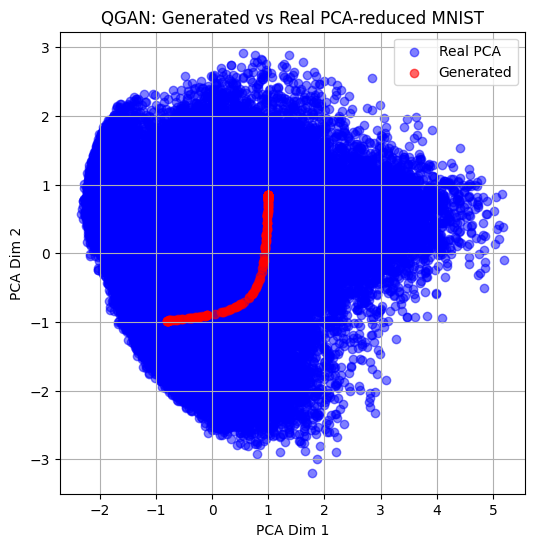

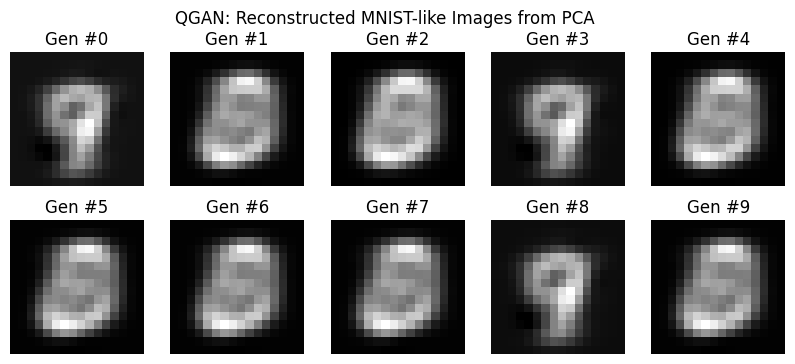

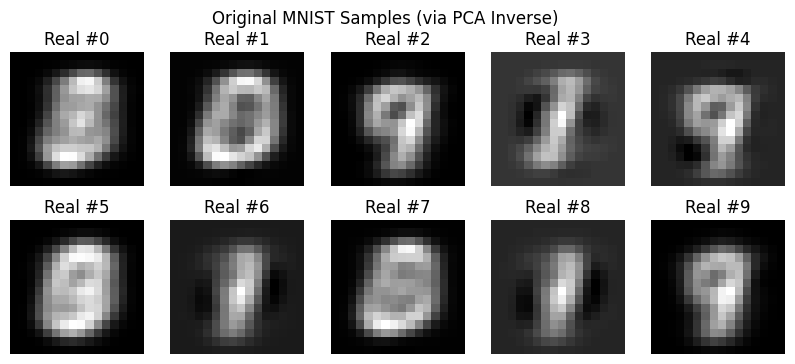

In [21]:
if __name__ == "__main__":
    main()